<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/Test_Again_Training_Exp02_to_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
Test Again_training_Exp02 to MNIST dataset<br>
* test
    * save epoch per latent vector
    * plot epoch per 2-dim vector

* Try Again, Fin...Fin...Fin...!!
* back to Original Kingma's VAE to Malimg
    * optimizer learning rate: 1e-3
    * optimizer params: sum to mean
* Add 
    * plot train, test loss
        * save it every Epochs
    * plot latent vector per 10 Epoch
        * save it every 10 Epoch
    * save model's state dict per 10 Epoch
    * save latent vector per 10 Epoch

* ✅ Check Point
    * Just try it again...!
    * 
    * 
    
## Reference
* Reference repository: https://github.com/pytorch/examples/tree/master/vae

* Reference for Visualization: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb


In [3]:
! nvidia-smi

Fri Jul  3 09:15:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [20]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
 
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import seaborn as sns

# save single numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.save.html#numpy.save
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [8]:
# Tutorial of VAE
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=16, shuffle=True)

# for visualizing extract 1000 samples from test dataset
test_loader_1000 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=1000, shuffle=True)

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

In [9]:
device = torch.device("cuda")  # device = torch.device("cuda")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(28*28, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)  # z's shape => (batch_size, 100)
        return self.decode(z), mu, logvar, z

In [10]:
model = VAE().to(device)
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=100, bias=True)
  (fc22): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=784, bias=True)
)


In [11]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# track and save train, test loss through Dictionary
# 
Epoch_Loss = {'train_epoch':[],
              'train_loss':[],
              'test_epoch':[],
              'test_loss':[]}

# Save & Loading Model for Inference
# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

# PATH = '/Again_original_Exp01_200-Epoch.pth'

PATH = 'Epochs.pth'
# latent_vector = np.zeros((16, 100))

color_palette = np.zeros((1000))

latent_vector = np.zeros((1000, 100))


In [21]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')  # (input, target, ... reduction)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    # latent_vector = np.zeros(())
    # latent_label = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        # print(_, _.shape, type(_))
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, z= model(data)
    
       
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    Epoch_Loss['train_epoch'].append(epoch)
    Epoch_Loss['train_loss'].append(train_loss / len(train_loader.dataset))
   
    '''
    # Epoch 단위 t-SNE plot 저장
    Z_embedded = TSNE(n_components=2).fit_transform(latent_vector.detach().cpu().clone().numpy())
    print(Z_embedded.shape)  # expect (16, 2)
    # https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
    plt.figure(figsize=(16,10))
    plt.xlim(Z_embedded[:, 0].min(), Z_embedded[:,0].max() + 1)
    plt.ylim(Z_embedded[:, 1].min(), Z_embedded[:,1].max() + 1)
    
    for i in range(len(Z_embedded[0])):
        plt.text(Z_embedded[i, 0], Z_embedded[i, 1], str(batch_idx),
                # color = colors[label[i]],
                fontdict={'weight':'bold', 'size':9})
    plt.xlabel("t-SNE feature 0")
    plt.ylabel("t-SNE feature 1")
    plt.savefig('./' + str(epoch) + '_t_SNE.png', dpi=300)
    '''
def test(epoch):
    if epoch % 10 !=0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_loader):
                data = data.to(device)
                recon_batch, mu, logvar, z = model(data)
                # z vector는 torch type
                # latent_vector = z.detach().cpu().clone().numpy()
                test_loss += loss_function(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                        recon_batch.view(16, 1, 28, 28)[:n]])
                    save_image(comparison.cpu(),
                            './test_result_MNIST/reconstruction_' + str(epoch) + '.png', nrow=n)
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))

    # 10 Epoch 단위로 작업
    # model.state_dict() 저장 및 latent_vector 저장
    # plot latent vector
    # elif epoch % 2 == 0:  # Epoch이 10의 배수일때
    # save model.state_dict() per 10 Epochs
    import numpy as np
    torch.save(model.state_dict(), ('/test_MNIST' + str(epoch) + PATH))  # Epoch 단위 parameter 저장

    # load_whole test_data 
    for i, (data, _) in enumerate(test_loader_1000):  # load_whole test_data
        data = data.to(device)
        recon_batch, mu, logvar, z = model(data)
    # save latent_vector per 10 Epochs
        latent_vector = z.detach().cpu().clone().numpy()  # change tensor type data to cpu().numpy()
                                                            # latent_vector_size: (num_of_data, 100)
        color_palette = _.detach().cpu().clone().numpy()

        with open(('Test'+str(epoch)+'Epoch_z_vector.npy'), 'wb') as f:
            np.save(f, latent_vector)  # but latent vector size is (16, 100).... just 16...
                                    # 10 Epoch 단위로 latent vector를 저장한다
                                    # 이 떄, latent vector의 size는 test_dataset의 크기가 되어야 한다
    

    Z_embedded = TSNE(n_components=2).fit_transform(latent_vector)
    import matplotlib as mpl
    import matplotlib.pylab as plt
    import pandas as pd
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

    x = Z_embedded[:, 0]  # define the data
    y = Z_embedded[:, 1]  # define the data
    tag = color_palette
    tag[10:12] = 0  # make sure there are some 0 values to show up as grey
    # print(tag)
    # print(tag.shape)
    # print(type(tag))
    # print(Z_embedded)
    # print(Z_embedded.shape)
    tsne_data = np.vstack(Z_embedded, tag)
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    '''
    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    cmaplist[0] = (.5, .5, .5, 1.0)

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(0, 20, 21)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # make the scatter
    scat = ax.scatter(x, y, c=tag,
                    cmap=cmap, norm=norm)

    # create a second axes for the colorbar
    ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

    ax.set_title('Well defined discrete colors')
    ax2.set_ylabel('Very custom cbar [-]', size=12)
    '''


    '''
    # plot latent vector Every 10 Epochs
    # t-SNE for Dimensionality reduction
    Z_embedded = TSNE(n_components=2).fit_transform(latent_vector)
    print(Z_embedded.shape)  # expect (16, 2) 
                                # https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

    # display a 2D plot of the digit classes in the latent space
    # x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    # plt.scatter(Z_embedded[:, 0], Z_embedded[:, 1], c=y_test)
    colors = 
    plt.scatter(Z_embedded[:, 0], Z_embedded[:, 1], c=color_palettem, cmap=matplotlib.colors.ListedColormap(colors)))

    plt.colorbar()
    '''
    # Ploting the result of tsne
    sn.FacetGrid(tsne_df, hue=”label”, size=6).map(plt.scatter, ‘Dim_1’, ‘Dim_2’).add_legend()
    # https://medium.com/@ranasinghiitkgp/t-sne-visualization-of-high-dimension-mnist-dataset-48fb23d1bafd
    # plt.show()

    plt.savefig('./Test_' + str(epoch) + '_t_SNE.png', dpi=300)
    plt.show()

SyntaxError: ignored

1
Train Epoch: 1 [0/60000 (0%)]	Loss: 110.293777
Train Epoch: 1 [160/60000 (0%)]	Loss: 120.198456
Train Epoch: 1 [320/60000 (1%)]	Loss: 107.909637
Train Epoch: 1 [480/60000 (1%)]	Loss: 96.609894
Train Epoch: 1 [640/60000 (1%)]	Loss: 112.193459
Train Epoch: 1 [800/60000 (1%)]	Loss: 118.690704
Train Epoch: 1 [960/60000 (2%)]	Loss: 111.609192
Train Epoch: 1 [1120/60000 (2%)]	Loss: 107.254150
Train Epoch: 1 [1280/60000 (2%)]	Loss: 108.746376
Train Epoch: 1 [1440/60000 (2%)]	Loss: 108.881119
Train Epoch: 1 [1600/60000 (3%)]	Loss: 108.548882
Train Epoch: 1 [1760/60000 (3%)]	Loss: 113.714684
Train Epoch: 1 [1920/60000 (3%)]	Loss: 117.091072
Train Epoch: 1 [2080/60000 (3%)]	Loss: 109.577492
Train Epoch: 1 [2240/60000 (4%)]	Loss: 110.340843
Train Epoch: 1 [2400/60000 (4%)]	Loss: 109.314400
Train Epoch: 1 [2560/60000 (4%)]	Loss: 107.930710
Train Epoch: 1 [2720/60000 (5%)]	Loss: 110.119835
Train Epoch: 1 [2880/60000 (5%)]	Loss: 112.251984
Train Epoch: 1 [3040/60000 (5%)]	Loss: 103.466003
Train Ep

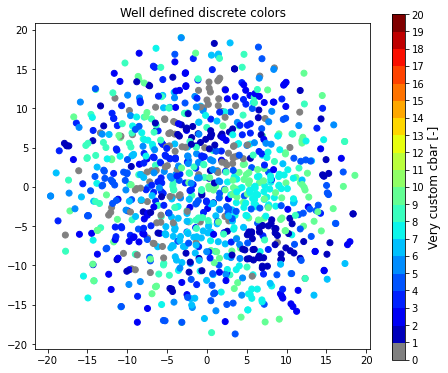

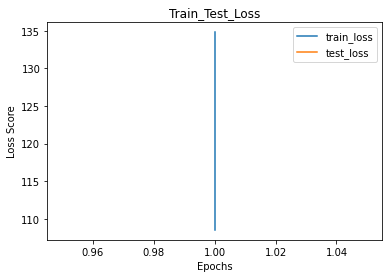

2
Train Epoch: 2 [0/60000 (0%)]	Loss: 106.134041
Train Epoch: 2 [160/60000 (0%)]	Loss: 112.560257
Train Epoch: 2 [320/60000 (1%)]	Loss: 105.480354
Train Epoch: 2 [480/60000 (1%)]	Loss: 119.592682
Train Epoch: 2 [640/60000 (1%)]	Loss: 108.637466
Train Epoch: 2 [800/60000 (1%)]	Loss: 104.575317
Train Epoch: 2 [960/60000 (2%)]	Loss: 104.186455
Train Epoch: 2 [1120/60000 (2%)]	Loss: 124.491882
Train Epoch: 2 [1280/60000 (2%)]	Loss: 110.521194
Train Epoch: 2 [1440/60000 (2%)]	Loss: 109.576897
Train Epoch: 2 [1600/60000 (3%)]	Loss: 108.357132
Train Epoch: 2 [1760/60000 (3%)]	Loss: 100.098061
Train Epoch: 2 [1920/60000 (3%)]	Loss: 115.047531
Train Epoch: 2 [2080/60000 (3%)]	Loss: 110.275284
Train Epoch: 2 [2240/60000 (4%)]	Loss: 110.480011
Train Epoch: 2 [2400/60000 (4%)]	Loss: 114.494453
Train Epoch: 2 [2560/60000 (4%)]	Loss: 97.071907
Train Epoch: 2 [2720/60000 (5%)]	Loss: 111.467972
Train Epoch: 2 [2880/60000 (5%)]	Loss: 102.656906
Train Epoch: 2 [3040/60000 (5%)]	Loss: 113.564835
Train Ep

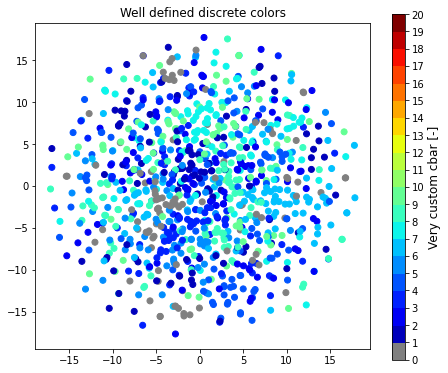

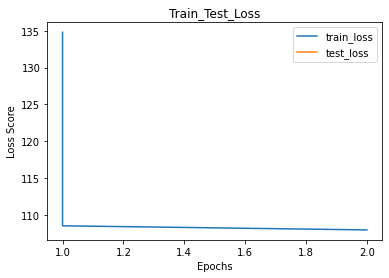

3
Train Epoch: 3 [0/60000 (0%)]	Loss: 107.517738
Train Epoch: 3 [160/60000 (0%)]	Loss: 108.008095
Train Epoch: 3 [320/60000 (1%)]	Loss: 106.450714
Train Epoch: 3 [480/60000 (1%)]	Loss: 108.043671
Train Epoch: 3 [640/60000 (1%)]	Loss: 114.656601
Train Epoch: 3 [800/60000 (1%)]	Loss: 97.759720
Train Epoch: 3 [960/60000 (2%)]	Loss: 111.393349
Train Epoch: 3 [1120/60000 (2%)]	Loss: 110.597374
Train Epoch: 3 [1280/60000 (2%)]	Loss: 100.648445
Train Epoch: 3 [1440/60000 (2%)]	Loss: 105.612381
Train Epoch: 3 [1600/60000 (3%)]	Loss: 118.574547
Train Epoch: 3 [1760/60000 (3%)]	Loss: 102.566689
Train Epoch: 3 [1920/60000 (3%)]	Loss: 108.255142
Train Epoch: 3 [2080/60000 (3%)]	Loss: 122.956711
Train Epoch: 3 [2240/60000 (4%)]	Loss: 116.121780
Train Epoch: 3 [2400/60000 (4%)]	Loss: 96.652908
Train Epoch: 3 [2560/60000 (4%)]	Loss: 111.050941
Train Epoch: 3 [2720/60000 (5%)]	Loss: 103.812248
Train Epoch: 3 [2880/60000 (5%)]	Loss: 99.375053
Train Epoch: 3 [3040/60000 (5%)]	Loss: 110.862206
Train Epoc

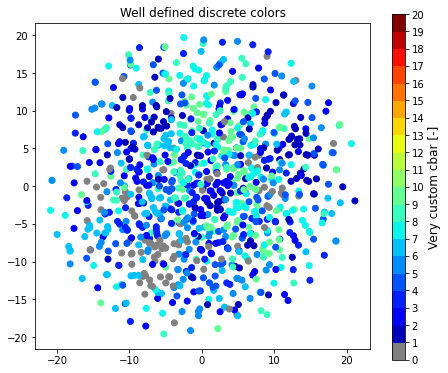

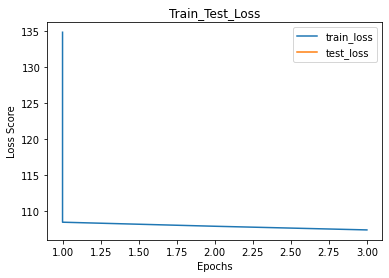

In [22]:
epochs = 3

for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)

        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss")
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./test_plot_MNIST/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()

        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       './test_result_MNIST/sample_' + str(epoch) + '.png')

In [ ]:


# Reference: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

encoder.save('encoder.h5')